In [1]:
from __future__ import division, absolute_import, print_function
import sys
import time
import pydot  # to regenerate the Graphviz figures you need 'dot' to be accessible in your path
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from brian import *
from brian.hears import *
from scipy import signal
from scipy.signal import butter, lfilter
from IPython.display import Audio
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
#set_global_preferences(useweave=True)  # uncomment to use faster C implementations in Brian
#set_global_preferences(gcc_options = ['-ffast-math -march=native'])
#set_global_preferences(openmp=True)  # uncomment to use multiple cores in Brian
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('ggplot')
print(sys.version)

2.7.12 |Anaconda 4.2.0 (32-bit)| (default, Jun 29 2016, 11:42:13) [MSC v.1500 32 bit (Intel)]


# <center>Signalverarbeitung und Codierung in Cochlea-lmplantaten</center>

<center>Dr. Stefan Strahl</center>

<center>1.12.2016</center>

Diese Vorlesung ist ein interaktives Jupyter Notebook
* verfügbar https://github.com/strahl/luebeck
* in jedem Browser lesbar über https://nbviewer.jupyter.org
* freies Experimentieren per http://jupyter.org Installation

##### Signalverarbeitung der  Hörbahn
![Äußeres Ohr, Mittelohr und Innenohr mit Hörschnecke, Sacculus und Bogengängen](images/Äußeres_Ohr_-_Mittelohr_-_Innenohr.jpg)
<div style="text-align: right;font-size:10pt">[Quelle: Wikipedia](https://commons.wikimedia.org/wiki/File:%C3%84u%C3%9Feres_Ohr_-_Mittelohr_-_Innenohr.jpg)</div>

Zuerst wollen wir uns genauer anschauen wie unser periphäres auditorisches System arbeitet. Die Geräusche gelangen hauptsächlich als Luftdruckänderungen durch den äusseren Gehörgang zum Trommelfell. Im Bereich des Mittelohrs lenkt dann das Trommelfell über die Impedanzwandler Hammer, Amboss und Steigbügel das ovale Fenster der Hörschnecke aus. Dadurch kommt die Perilymphe im Innenohr in Schwingung.

#####  Frequenz-Orts-Transformation
![Uncoiled Basilar Membrane](images/Uncoiled_cochlea_with_basilar_membrane.png)
<div style="text-align: right;font-size:10pt ">[Quelle: Wikipedia](https://commons.wikimedia.org/wiki/File:Uncoiled_cochlea_with_basilar_membrane.png)</div>

Die durch den Schall erzeugt Wanderwelle läuft durch das Innenohr. Was fällt auf wenn man sich die Basilarmembran anschaut? Die Breite der Basilarmembran nimmt Richtung Apex zu. Da gleichzeitig der Durchmesser des knöchernen Schneckenkanals abnimmt, ändern sich die Schwingungseigenschaften des Systems von steif und resonant mit hohen Frequenzen am Anfang zu nachgiebig und resonant mit niedrigen Frequenzen am Apex.

#####  Hörnervenanregung
![Cochlea crosssection](images/Cochlea-crosssection-de.png)
<div style="text-align: right;font-size:10pt">[Quelle: Wikipedia](https://commons.wikimedia.org/wiki/File:Cochlea-crosssection-de.png)</div>

Mit der  Auslenkung der Basilarmembran werden die inneren Haarzellen angeregt. Der Reiz löst ein elektrisches Signal in den Haarzellen aus (mechano-elektrische Transduktion). Diese geben ein chemisches Signal (Transmitter Glutamat) an eine Hörnervenfaser (Transformation), wodurch jede Hörnervenfaser die Frequenzselektion ihrer angeschlossenen inneren Haarzelle weitergibt. Die Hörnervenfasern reagieren elektrisch (Aktionspotential) und reichen bis zum ersten Kerngebiet der Hörbahn im Stammhirn.

Im nächsten Abschnitt wollen wir diese Etappen in der Höhrbahn simulieren:

In [2]:
def simulate_acoustic(sound, level):
    '''
    Simulates acoustic excitsation of the auditory nerve
    sound - acoustic input (class: Sound)
    level - sound pressure level (dB SPL)
    '''
    basilar_membran_position_mm = np.linspace(0, 32, 200)  # we simulate neurons equispaced along the basilar membrane
    cfmin, cfmax, cfN = 20*Hz, 20*kHz, len(basilar_membran_position_mm)
    center_frequencies = erbspace(cfmin, cfmax, cfN)  # get corresponding frequencies
    
    sound.level = level
    gfb = Gammatone(sound, center_frequencies)
    gt_mon = gfb.process()
    ihc = FunctionFilterbank(gfb, lambda x: 3*clip(x, 0, Inf)**(1.0/3.0))
    ihc_mon = ihc.process()
    # Leaky integrate-and-fire model with noise and refractoriness
    eqs = '''
    dv/dt = (I-v)/(1*ms)+0.2*xi*(2/(1*ms))**.5 : 1
    I : 1
    '''
    G = FilterbankGroup(ihc, 'I', eqs, reset=0, threshold=1, refractory=5*ms)
    # Run, and raster plot of the spikes
    M = SpikeMonitor(G)
    run(sound.duration)

    fig, axes2d = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
    axes = axes2d.flatten()
    axes[0].plot(1e3*sound.times, sound);
    axes[0].set_ylabel('Amplitude (Pa)');
    axes[0].set_title('Tonsignal')
        
    plt.sca(axes[1])
    plt.imshow(gt_mon.T, aspect='auto', origin='lower left',
           extent=(0, sound.duration/ms,
                   1e-3*center_frequencies[0], 1e-3*center_frequencies[-1]))
    axes[1].set_title('Basilarmembranauslenkung');
    axes[1].set_ylabel('Frequenz (kHz)');
    axes[1].set_yticks(center_frequencies[::49]*1e-3, minor=False)
    ax2 = axes[1].twinx()    
    ax2.set_ylim(axes[1].get_ylim())
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.yticks(axes[1].get_yticks(), ["{:1.1f}".format(c) for c in basilar_membran_position_mm[[0,49,98,147,196]]])
    ax2.set_ylabel('Position (mm)')    

    plt.sca(axes[2])
    plt.imshow(ihc_mon.T, aspect='auto', origin='lower left',
           extent=(0, sound.duration/ms,
                   1e-3*center_frequencies[0], 1e-3*center_frequencies[-1]))
    axes[2].set_title('IHC Antwort');
    axes[2].set_ylabel('Frequenz (kHz)');
    axes[2].set_xlabel('Zeit (ms)');
    axes[2].set_yticks(center_frequencies[::49]*1e-3, minor=False)
    
    plt.sca(axes[3])
    raster_plot(M)
    axes[3].set_title(u'Hörnervenaktivität');
    axes[3].set_xlabel('Zeit (ms)');
    axes[3].set_ylabel('Neuron');    
    axes[3].set_ylim((0,len(M.spiketimes)))
    ax2 = axes[3].twinx()    
    ax2.set_ylim(axes[3].get_ylim())
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.yticks(axes[3].get_yticks(), ["{:1.1f}".format(c) for c in basilar_membran_position_mm[[0,50,100,150,199]]])
    ax2.set_ylabel('Position (mm)')    

    fig.tight_layout() 
    return M

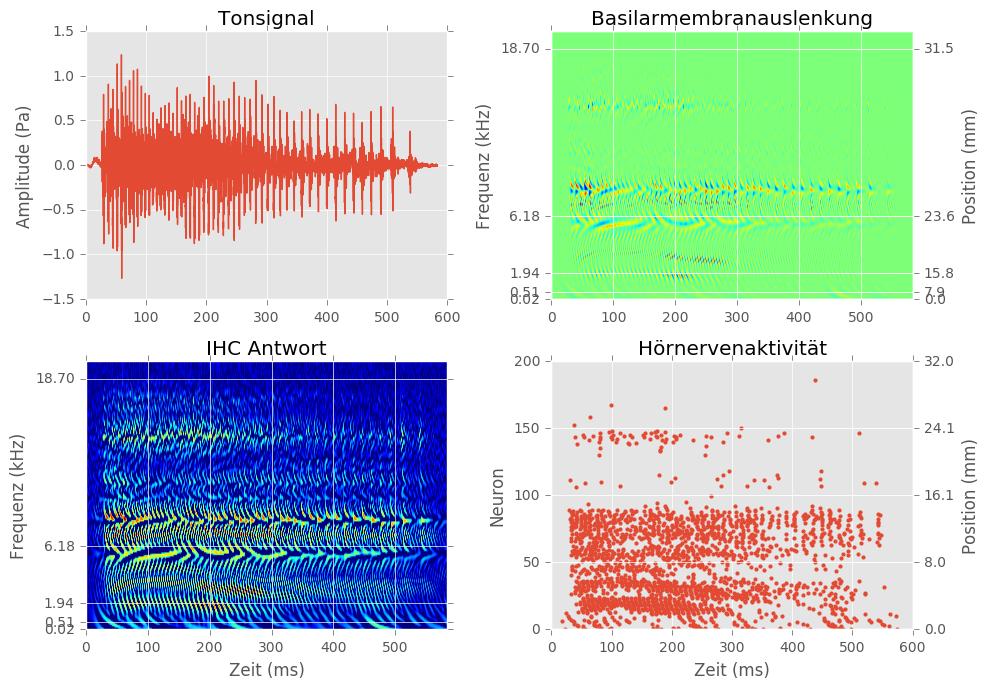

In [24]:
sound = tone(170*Hz, .1*second)
# Hier können eigene Beispiele ausprobiert werden, z.B. 
sound = tone(100*Hz, .1*second) + tone(150*Hz, .1*second) + tone(200*Hz, .1*second)
sound = loadsound('sounds/Open_front_unrounded_vowel.wav')  # Vokal
an_response_acoustic = simulate_acoustic(sound, 80*dB)
Audio(data=np.array(sound).T, rate=sound.samplerate)

Bei dem 100 Hz Sinuston sieht man sehr schön das Phaselocking der Nervenfasern, d.h. die Neurone feuern nur ca. alle 10 ms. Es steht dem auditorischen System also neben der Ortskodierung (oft "place-coding" gennant) auch eine Zeitinformation zur Verfügung ("time-coding"). Wenn wir drei Sinustöne (100, 150, 200 Hz) sehen wir Zeitversatz der Wanderwelle. Wir sehen auch die Anregungsbreite. Wenn wir 100, 300, 500 Hz ausprobieren sehen wir erst ein Trennung der Kanäle. Die nichtlineare Frequenzachse, die auch rechts an der Basilarpos in mm Achse gut erkennbar.

Beim Vokal und Sprachbeispiel sieht man: Es gibt eine Einhüllende (2-20 Hz), eine Periodizität aufgrund der F0 Grundfrequenz und eine zeitliche Feinstruktur.

Jetzt kennen wir die Verarbeitung unseres Hörsystems vom Schall zur den Aktionspotentialen im Hörnerven.

##### Aufbau eines Cochleaimplantats
![MED-EL CONCERTO](images/medel_durchsicht.jpg)
<div style="text-align: right;font-size:10pt">[Quelle: MED-EL](https://www.medel.com)</div>

Ein CI kann direkt die Hörnerven stimulieren wenn der normale Signalweg gestört ist. Ein typisches Cochleaimplantat besteht aus einer Spule mit einem Magneten, einem Gehäuse für die Stimulationslogik, einem Elektrodenarray mit Kontakten sowie mindestens einer Referenzelektrode bezüglich der Stimulation sowie optional einer Referenzelektrode für etwaige Spannungsmessungen.

Wo würdet ihr den Elektrodenträger implantieren?
![Henry Gray (1918) Anatomy of the Human Body](images/Gray928.png)
<div style="text-align: right;font-size:10pt">[Quelle: Gray (1918)](https://commons.wikimedia.org/wiki/File:Gray928.png)</div>

In der Scala tympani
![Henry Gray (1918) Anatomy of the Human Body](images/Gray928_electrode.png)
<div style="text-align: right;font-size:10pt">[Quelle: Gray (1918)](https://commons.wikimedia.org/wiki/File:Gray928.png)</div>

In [4]:
(graph,) = pydot.graph_from_dot_data("digraph G {rankdir = LR node [shape=box]; A [label=\"Mikrofon\"]; B [label=\"Vor-\nverarbeitung\"]; C [label=\"Stimulations-\nstrategie\"]; D [label=\"RF\nSpule\"]; E [label=\"Dekoder\"]; F [label=\"Puls\nErzeugung\"]; G [label=\"Elektroden\"]; A -> B; B -> C; C -> D; D -> E; E -> F;  F -> G}")
graph.write_svg('./images/signal_chain_basic.svg');

#####  Signalverarbeitung eines CI
![Signalverarbeitung Grundaufbau](images/signal_chain_basic.svg)

__Mikrofon__
* üblicher Frequenzbereich von 100 - 8000 Hz
* 1-2 omnidirektionale Mikrofone 

![Signalverarbeitung Grundaufbau](images/signal_chain_basic.svg)

__Vorverarbeitung__: 
* Automatische Verstärkungsregelung (AGC)
* Beamforming
* Windgeräuschunterdrückung
* ...

![Signalverarbeitung Grundaufbau](images/signal_chain_basic.svg)

__Stimulationsstrategie__:
* Erzeugung des Stimulationsmuster
* Generierung des digitalen Datenwortes
* kennt die individuelle Anpassung des CI Nutzers

![Signalverarbeitung Grundaufbau](images/signal_chain_basic.svg)

__RF Spule__:
* Übertragung des digitalen Datenwortes durch die Haut in den implantierten Stimulator
* gleichzeitige Energieversorgung

![Signalverarbeitung Grundaufbau](images/signal_chain_basic.svg)

__Dekoder__:
* Dekodierung der RF Signale
* Prüfsummenberechnung

![Signalverarbeitung Grundaufbau](images/signal_chain_basic.svg)

__Pulserzeugung__:
* eine oder mehrere Stromquellen
* Kanal: zwei oder mehr Elektroden zwischen denen ein Stromfluss stattfindet

![Signalverarbeitung Grundaufbau](images/signal_chain_basic.svg)

__Elektroden__:
* 12-24 intracochleäre Elektroden
* 1-3 Referenzelektroden am Stimulatorgehäuse
* monopolar: entferne Referenzelektrode
* bipolar: Strom fliesst zwischen zwei intracochleären Elektroden

######  3.1 Einkanalige Stimulation
House Ear Institute, USA (1961):
* Bandpassfilter: 340-2700 Hz
* Modulation analoger 16 kHz Träger
* Satzerkennung kaum möglich
![3M/House single-channel cochlear implant](images/Houseimplant_large.jpg)
<div style="text-align: right;font-size:10pt">[Quelle: Washington University School of Medicine](http://beckerexhibits.wustl.edu/did/win_tl/Houseimplant.htm)</div>

In [5]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def simulate_house(sound):
    basilar_membran_position_mm = np.linspace(0, 32, 200)  # 
    cfmin, cfmax, cfN = 20*Hz, 20*kHz, len(basilar_membran_position_mm)
    center_frequencies = erbspace(cfmin, cfmax, cfN)
    
    bandpass = IIRFilterbank(source=sound, nchannels=1, passband=np.array((340*Hz, 2700*Hz)), stopband=np.array((300*Hz, 3000*Hz)), gpass=1.*dB, gstop=10.*dB, btype='bandpass', ftype='cheby1')
    bp_mon = bandpass.process()
    carrier = np.sin(16000*2*np.pi*sound.times)
    processed = Sound(bp_mon[:,0] * carrier, samplerate=sound.samplerate)

    energy = FunctionFilterbank(processed, lambda x: abs(x))
    impulse_response = zeros((len(basilar_membran_position_mm),1))
    impulse_response[:,0] = 5*gaussian(np.arange(len(basilar_membran_position_mm)), 150, 10)
    electric_field = FIRFilterbank(energy, impulse_response)
    ef_mon = electric_field.process()

    # Leaky integrate-and-fire model with noise and refractoriness
    eqs = '''
    dv/dt = (I-v)/(1*ms)+0.2*xi*(2/(1*ms))**.5 : 1
    I : 1
    '''
    G = FilterbankGroup(2*electric_field, 'I', eqs, reset=0, threshold=1, refractory=5*ms)
    # Run, and raster plot of the spikes
    M = SpikeMonitor(G)
    run(sound.duration)

    plt.rcParams['figure.figsize'] = (10, 7)

    ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=3)
    ax2 = plt.subplot2grid((2, 6), (0, 3), colspan=3)
    ax3 = plt.subplot2grid((2, 6), (1, 0), colspan=2)
    ax4 = plt.subplot2grid((2, 6), (1, 2), colspan=2) 
    ax5 = plt.subplot2grid((2, 6), (1, 4), colspan=2) 

    plt.sca(ax1)        
    plt.plot(1e3*sound.times, sound);
    plt.xlabel('Zeit (ms)');
    plt.ylabel('Amplitude (Pa)');
    plt.title('Tonsignal')

    # bandpass filter & 16 kHz carrier
    plt.sca(ax2)
    plt.plot(1e3*sound.times, bp_mon);
    plt.plot(1e3*sound.times, processed);
    plt.xlabel('Zeit (ms)');
    plt.ylabel('Spannung (V)');
    plt.title('Verarbeitetes Signal')
    axins = inset_axes(ax2, width="30%", height="30%", loc=1)
    axins.plot(1e3*sound.times, bp_mon);
    axins.plot(1e3*sound.times, processed);
    axins.set_xlim(301, 303)
    axins.set_ylim(-0.55, 0.55)
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    mark_inset(ax2, axins, loc1=2, loc2=4, fc="none", ec="0.5")
    
    # spread of excitation
    plt.sca(ax3)
    imshow(ef_mon.T, aspect='auto', origin='lower left',
               extent=(0, sound.duration/ms, 1e-3*center_frequencies[0], 1e-3*center_frequencies[-1]))
    plt.xlabel('Zeit (ms)');
    plt.ylabel('Frequenz (kHz)');
    plt.title('Elektrische Anregung')

    plt.sca(ax4)
    # Leaky integrate-and-fire model with noise and refractoriness
    raster_plot(M)
    ylabel('Neuron');    
    xlabel('Zeit (ms)');
    ylim((0,len(basilar_membran_position_mm)));
    plt.title('Nervenantwort elektrisch')

    plt.sca(ax5)
    raster_plot(an_response_acoustic)
    ylabel('Neuron');
    xlabel('Zeit (ms)');
    ylim((0,len(basilar_membran_position_mm)));
    plt.title('Nervenantwort akustisch')
    
    plt.gcf().tight_layout()
    return processed

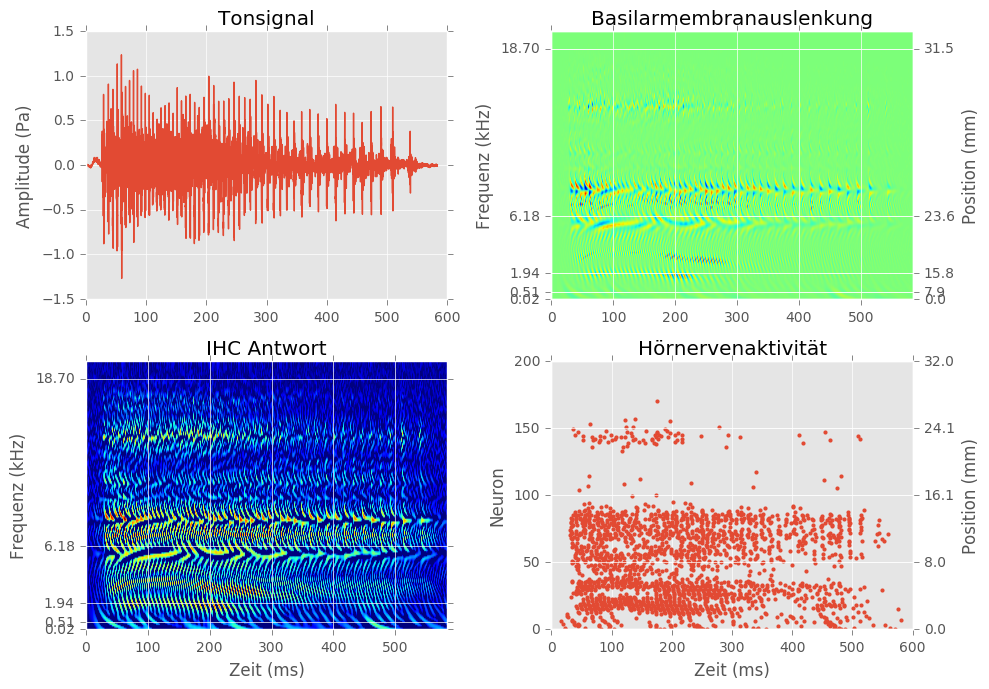

In [6]:
sound = loadsound('sounds/Open_front_unrounded_vowel.wav')
an_response_acoustic = simulate_acoustic(sound, 80*dB)

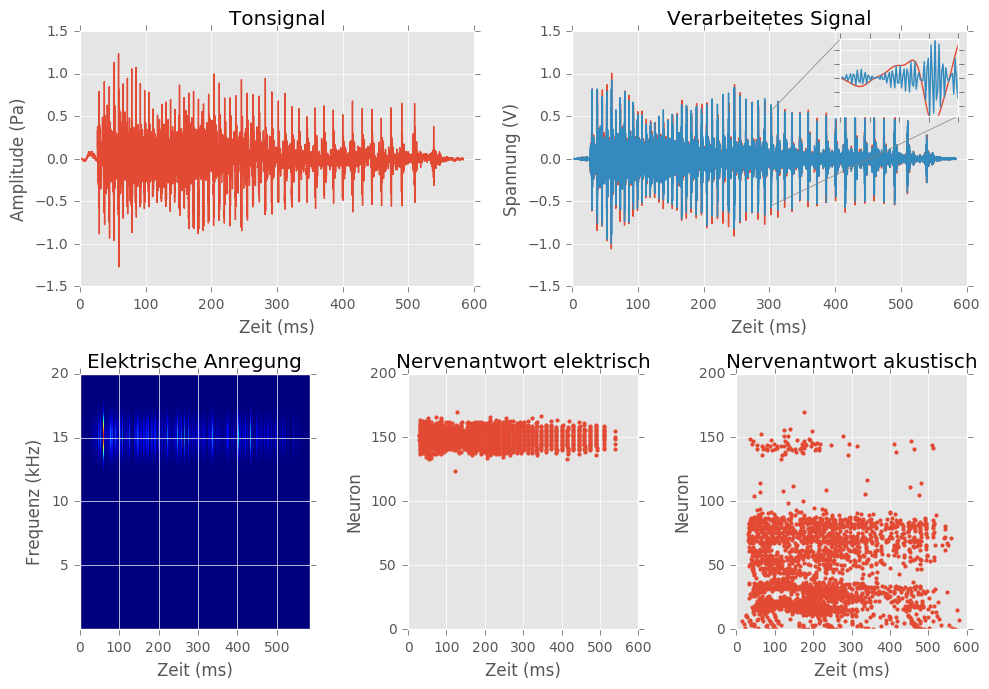

In [7]:
processed = simulate_house(sound)

#####  3.2 Mehrkanalige Stimulation
* Ende der 70er ersten mehrkanalige CIs entwickelt.
* 1977 wurde z.B. in Wien ein 8-Kanal CI implantiert.

![](images/1977_multichannel.jpg)
<div style="text-align: right;font-size:10pt">[Quelle: MED-EL](https://www.medel.com)</div>

Wie ändert sich der Perzept mit der Anzahl der Kanäle?

In [8]:
def gen_bandpassnoise(lowcut, highcut, samples, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, np.random.rand(samples))
    return y

def sonify_CI(sound, num_electrodes, cfmin=1000*Hz, cfmax=16e3*Hz, quantization_ms=5):
    if num_electrodes == 1:
        electrode_cfs = [cfmax+cfmin/2]
    else:
        electrode_cfs = erbspace(cfmin, cfmax, num_electrodes)
    
    stepSize_pts = int(np.round(1e-3*quantization_ms * sound.samplerate))
    numData = sound.nsamples
    time = np.arange(stepSize_pts)/sound.samplerate
    sound_out = np.zeros(numData)

    gfb = Gammatone(sound, electrode_cfs)
    gfb_mon = gfb.process().T
           
    stimData = np.zeros((num_electrodes, stepSize_pts))
    for jj in range(num_electrodes):
        stimData[jj,:] = np.sin(2*np.pi*electrode_cfs[jj]*time)  # sinus
        #stimData[jj,:] = gen_bandpassnoise(electrode_cfs[jj]*0.9, electrode_cfs[jj]*1.1, stepSize_pts, fs=sound.samplerate) # bandpass noise
        # todo: use bandpass noise
                
    for ii in np.arange(0, numData-stepSize_pts+1, stepSize_pts, dtype=int):        
        energy = np.sum(gfb_mon[:,ii:(ii+stepSize_pts)]**2, 1)                             
        newStim = energy.T.dot(stimData)
        sound_out[ii:(ii+stepSize_pts)] = newStim                
    
    # normalize sound
    sound_out = sound_out - np.min(sound_out)
    sound_out = 2*sound_out/np.max(sound_out)-1
    
    t = np.arange(len(sound))/sound.samplerate
    plt.rcParams['figure.figsize'] = (10, 7)
    plt.subplot(2,2,1)
    plt.plot(t, sound)
    plt.xlabel('Zeit (s)');
    plt.ylabel('Amplitude (Pa)');
    plt.title('Tonsignal')
    plt.subplot(2,2,2)
    sound.spectrogram()
    plt.title('Spectrogram Tonsignal')
    plt.xlabel("Zeit (s)")
    plt.ylim(0,15000)
    plt.subplot(2,2,3)
    plt.plot(t, sound_out)
    plt.xlabel("Zeit (s)")
    plt.ylabel("Amplitude (Pa)")
    plt.title('simuliertes CI Signal')
    plt.subplot(2,2,4)
    Sound(sound_out, samplerate=sound.samplerate).spectrogram()
    plt.ylim(0,15000)
    plt.plot(t[-1]*np.ones((len(electrode_cfs,))),electrode_cfs,"w*", ms=10.0)
    plt.xlabel("Zeit (s)")
    plt.title('Spectrogram simuliertes CI Signal')
    plt.gcf().tight_layout() 
    
    return sound_out, electrode_cfs

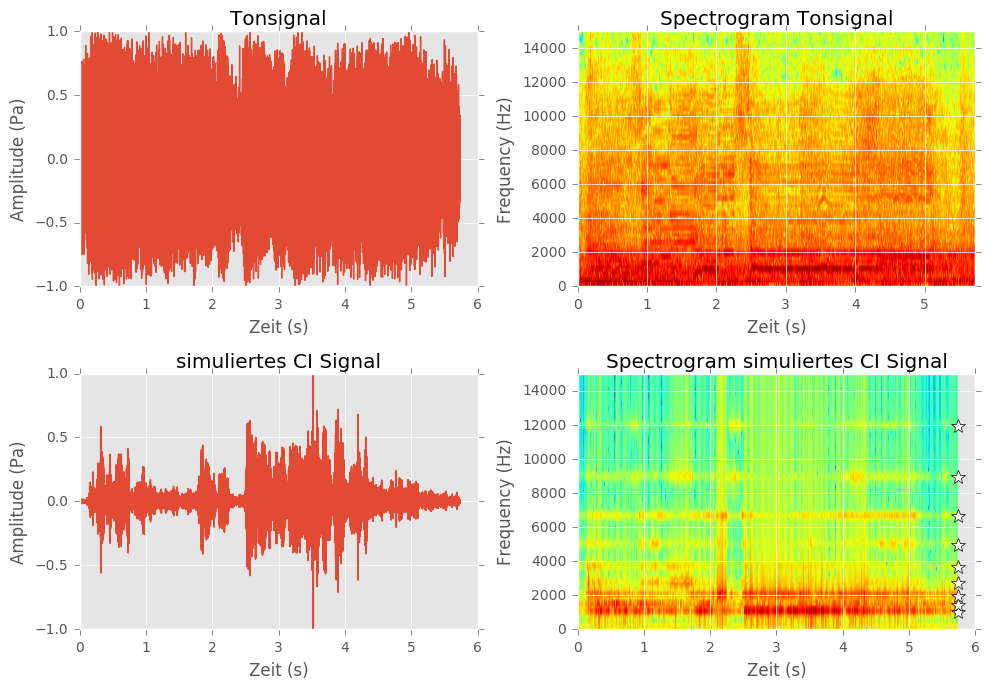

In [39]:
#sound = loadsound('sounds/Open_front_unrounded_vowel.wav')
#sound = loadsound('sounds/voice1.wav')
sound = loadsound('sounds/music1.wav')
sound_ci, electrode_cfs = sonify_CI(sound, num_electrodes=10, cfmin=1000*Hz, cfmax=16e3*Hz)
#sound_ci, electrode_cfs = sonify_CI(sound, num_electrodes=30, cfmin=300*Hz, cfmax=16e3*Hz)
Audio(data=sound_ci, rate=sound.samplerate)
#Audio(data=sound.T, rate=sound.samplerate)

Könnt ihr das Sprach- und Musikbeispiel erraten?

Die Sterne zeigen die Mittenfrequenzen der Stimulationskanäle auf der Basilarmembran. Wie im akustischen Modell schon gesehen, sind die Position in der Hörschnecke nicht äquidistant über die Frequenzachse. Das bedeutet dass die meisten CIs nur die Nervenfasern für die hohen und mittleren Frequenzen erreichen. Wie ändert sich der Ton wenn ich die Positionen der Elektroden verändere?

Trotzdem war der Erfolg der meisten Mehrkanal-CI Nutzer nicht befriedigend. Der Grund war die breite der elektrischen Anregung. Was meint ihr um wieviel dB das elektrisch Feld pro Millimeter abfällt?

3.12 dB/mm (Kral et al. 1998)

Kral A, Hartmann R, Mortazavi D, Klinke R. Spatial resolution of cochlear implants: the electrical field and excitation of auditory afferents. Hear. Res. 1998;121:11–28.

##  3.3 Aktuelle Stimulationsstrategien
##  3.3.1 Continuous Interleaved Sampling (CIS)
* Zeitlicher Versatz der Stimulationspulse (Kanalübersprechen)
* Hohe Stimulationsrate
* Kodiert viel grösseres Spektrum als bisher

Erst mit CIS erreichten viele CI Nutzer ein offenes Sprachverständnis.

![](images/Continuous_Interleaved_Sampling.jpg)
<div style="text-align: right;font-size:10pt">[Quelle: Wikipedia](https://commons.wikimedia.org/wiki/File:Continuous_Interleaved_Sampling.jpg)</div>



Audiosignal |  Spektrogram | Elektrodenaktivierungsmuster
:-------------------------:|:-------------------------:|:-------------------------:
![](images/Wouters2015_Fig5_waveform.png)  |  ![](images/Wouters2015_Fig5_spectrogram.png) | ![](images/Wouters2015_Fig5_CIS.png)
<div style="text-align: right;font-size:10pt">[Quelle: Wouters et al. (2015)](http://ieeexplore.ieee.org/document/7038260/?tp=&arnumber=7038260)</div>

##  3.3.2 ACE

* Fast identisch mit CIS
* In jedem Stimulationszklus:
    * stimuliere nur Untermenge der Elektroden (z.B. 8 aus 22) mit höchster Energie
* Implizite Rauschreduktion die in entsprechenden Hörsituation Vorteile zeigt

Audiosignal |  Spektrogram | Elektrodenaktivierungsmuster
:-------------------------:|:-------------------------:|:-------------------------:
![](images/Wouters2015_Fig5_waveform.png)  |  ![](images/Wouters2015_Fig5_spectrogram.png) | ![](images/Wouters2015_Fig5_ace.png)
<div style="text-align: right;font-size:10pt">[Quelle: Wouters et al. (2015)](http://ieeexplore.ieee.org/document/7038260/?tp=&arnumber=7038260)</div>

## 3.3.3 MP3000
* Fast identisch mit ACE
* Auswahl der Untermenge der Stimulationselektroden erfolgt mittels psychoakustischem Model
* Keine signifikante Verbesserung zu ACE gezeigt
* 24% längere Batterielaufzeiten

Audiosignal |  Spektrogram | Elektrodenaktivierungsmuster 
:-------------------------:|:-------------------------: |:-------------------------:
![](images/Wouters2015_Fig5_waveform.png)  |  ![](images/Wouters2015_Fig5_spectrogram.png) | ![](images/Wouters2015_Fig5_mp3000.png)
<div style="text-align: right;font-size:10pt">[Quelle: Wouters et al. (2015)](http://ieeexplore.ieee.org/document/7038260/?tp=&arnumber=7038260)</div>

## 3.3.4 FSP / FS4
* Alle bisherigen Kodierungsstrategien übertragen die Information über den Ort (place-coding) mit einer festen Rate
* Idee: Wiedergabe der zeitlichen Hörnervenmuster (time-coding) an den tieffrequenten apikalen Elektroden (1-4 Kanäle)
* Zeigt hauptsächlich Verbesserungen bei der Musikwahrnehmung

![](images/medel_finehearing-time-coding.jpg)
<div style="text-align: right;font-size:10pt">[Quelle: MED-EL](https://www.medel.com)</div>

Audiosignal |  Spektrogram | Elektrodenaktivierungsmuster
:-------------------------:|:-------------------------:|:-------------------------:
![](images/Wouters2015_Fig5_waveform.png)  |  ![](images/Wouters2015_Fig5_spectrogram.png) | ![](images/Wouters2015_Fig5_fsp.png)
<div style="text-align: right;font-size:10pt">[Quelle: Wouters et al. (2015)](http://ieeexplore.ieee.org/document/7038260/?tp=&arnumber=7038260)</div>

## 3.3.5 HiRes120
* Bipolare Stimulation
* Aktive Steuerung des Anregungsortes (120 virtuelle Kanäle bei 16 Elektroden)
* Die meisten CI Nutzer zeigen keine Verbesserung bei der Sprach- oder Musikwahrnehmung
    * Untergruppen existieren die signifkant besser sowie schlechter werden
    * Der neuronale Status der Cochlea scheint hier entscheidend zu sein 


![](images/AB_HiRes120.png)
<div style="text-align: right;font-size:10pt">[Quelle: Advanced Bionics](https://www.advancedbionics.com)</div>

Audiosignal |  Spektrogram | Elektrodenaktivierungsmuster
:-------------------------:|:-------------------------:|:-------------------------:
![](images/Wouters2015_Fig5_waveform.png)  |  ![](images/Wouters2015_Fig5_spectrogram.png) | ![](images/Wouters2015_Fig5_hires120.png)
<div style="text-align: right;font-size:10pt">[Quelle: Wouters et al. (2015)](http://ieeexplore.ieee.org/document/7038260/?tp=&arnumber=7038260)</div>

Welche Satzerkennungsrate schätzt ihr erreichen die modernen Kodierungsstrategien

Alle aktuellen Kodierungsstrategien erreichen eine Satzerkennungsrate von ca. 80%.

![](images/Zeng2008Fig3.png)
<div style="text-align: right;font-size:10pt">[Quelle: Zeng at al. (2008)](http://ieeexplore.ieee.org/document/4664429/)</div>
